Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing all the important libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
# supress tensorflow warnings
tf.get_logger().setLevel('ERROR')

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Create a dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height,img_width),
            label_mode='categorical',
            seed=123,
            subset="training",
            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          batch_size=batch_size,
          image_size=(img_height,img_width),
          label_mode='categorical',
          seed=123,
          subset="validation",
          validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List of all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**

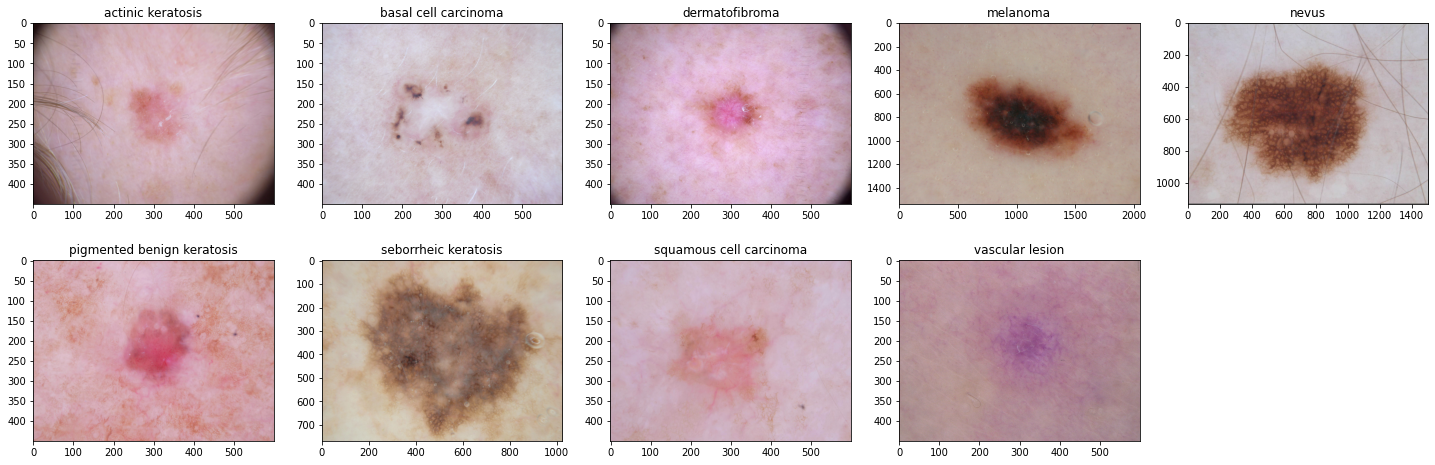

In [ ]:
#plotting an image of each class
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**

In [ ]:
input_shape = (img_height,img_width,3)

model = Sequential() 

#First Convolution Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #flattens the multi-dimensional input tensors into a single dimension

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function
model.add(layers.Dense(len(class_names),activation='softmax'))

### **Compile the model**

In [ ]:
### compile the function with adam optimizer & categorical cross entropy
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### **Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 282s 1s/step - loss: 2.0906 - accuracy: 0.2550 - val_loss: 1.8003 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6542 - accuracy: 0.4046 - val_loss: 1.7169 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5733 - accuracy: 0.4342 - val_loss: 1.5375 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4393 - accuracy: 0.4805 - val_loss: 1.4812 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3559 - accuracy: 0.5162 - val_loss: 1.3207 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2868 - accuracy: 0.5508 - val_loss: 1.3398 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1870 - accuracy: 0.5737 - val_loss: 1.3581 - val_accuracy: 0.5481
Epoch 8/20
56

### **Visualizing training results**

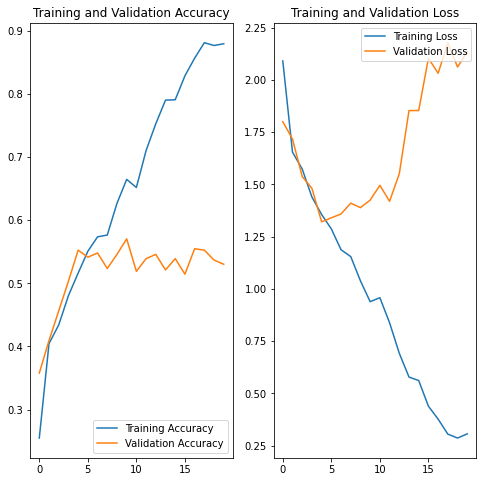

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings :**
1. The training accuracy increases over time, where as the
validation accuracy stall at around 50% accuracy in training process.
2. As the training loss decreases with epochs the validation loss increases.
3. The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around 50% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.

### **Choosing a data augmentation strategy**

In [ ]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

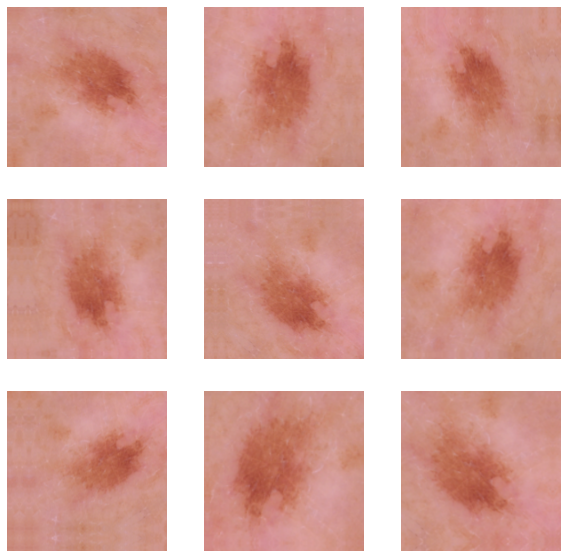

In [ ]:
#Visualize the augmentated image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### **Creating the model**


In [ ]:
model2 = Sequential()  

model2.add(data_augmentation)             #Augmentation layer
model2.add(layers.experimental.preprocessing.Rescaling(1./255))                       #Rescaling layer

#First Convolution Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop
model2.add(layers.Dropout(0.25))

#Second Convolution Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop
model2.add(layers.Dropout(0.25))

#Third Convolution Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#flatten the multi-dimensional input tensors into a single dimension
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function
model2.add(layers.Dense(len(class_names),activation='softmax'))

### **Compiling the model**

In [ ]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

### **Training the model**

In [ ]:
epochs =20
history = model2.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 23s 303ms/step - loss: 2.3770 - accuracy: 0.1948 - val_loss: 2.0698 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 16s 285ms/step - loss: 1.9685 - accuracy: 0.2679 - val_loss: 1.9919 - val_accuracy: 0.2260
Epoch 3/20
56/56 [==============================] - 17s 296ms/step - loss: 1.8211 - accuracy: 0.3287 - val_loss: 1.7494 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 17s 312ms/step - loss: 1.6917 - accuracy: 0.3783 - val_loss: 1.6634 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 16s 287ms/step - loss: 1.6827 - accuracy: 0.3733 - val_loss: 1.5471 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 16s 282ms/step - loss: 1.5793 - accuracy: 0.4481 - val_loss: 1.5059 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 17s 298ms/step - loss: 1.5702 - accuracy: 0.4375 - val_loss: 1.5356 - val_accuracy: 0.4743

### **Visualizing the results**

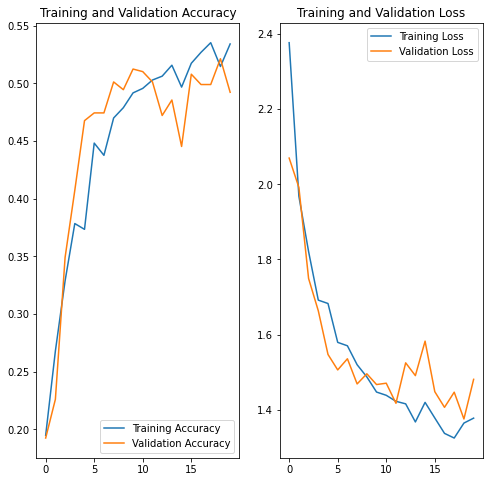

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings :**
1. Both the training and validation accuracy increase over time and then remain around 50% accuracy in training process. 
2. Both the training and validation losses decrease with training and do not have much difference between them.
3. The plots show that training accuracy and validation accuracy are not off by large margins as compared to previous model, and this model has achieved around 50% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is not that much noticeable. Hence, the problem of overfitting has reduced to an extent due to data augmentation.

Since, the accuracy is much low on both trainning and validation sets, we need to find a solution for this.

### **Detecting class imbalance**

In [ ]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


###### **Findings :**
###### - **Which class has the least number of samples?**
seborrheic keratosis with 77 samples
###### - **Which classes dominate the data in terms proportionate number of samples?**
pigmented benign keratosis with 462 samples

### **Rectify the class imbalance**

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F5DE02370>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F5DE90EB0>: 100%|██████████| 500/500 [00:25<00:00, 19.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F5DE90A60>: 100%|██████████| 500/500 [00:23<00:00, 21.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F6A5D23D0>: 100%|██████████| 500/500 [01:44<00:00,  4.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F9F5DD826D0>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FF10FF610>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9FF11391C0>: 100%|██████████| 500/500 [00:48<00:00, 10.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F5DF28520>: 100%|██████████| 500/500 [00:19<00:00, 25.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FF0052A30>: 100%|██████████| 500/500 [00:21<00:00, 22.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Lets see the distribution of augmented data after adding new images to the original training data**

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_b78c4ad2-2313-4807-9a4a-b672f63e85c9.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_e38d4446-5bbd-445a-a099-7b21d47eade0.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_fc8ac39d-eca9-48a5-b56d-a2b31d858254.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_048e934c-dcc9-4491-a4ff-cf83f27c089f.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_91ccf9f9-794a

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Train the model on the data created using Augmentor**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### **Create a training dataset**

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### **Create a validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Create a model**

In [ ]:
model3 = Sequential()

model3.add(layers.experimental.preprocessing.Rescaling(1./255))   #Rescaling Layer

#First Convolution layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convolution Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convolution Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function
model3.add(layers.Dense(len(class_names),activation='softmax'))

### **Compile model**

In [ ]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### **Train model**

In [ ]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 39s 206ms/step - loss: 2.5260 - accuracy: 0.1708 - val_loss: 4.4431 - val_accuracy: 0.1396
Epoch 2/30
169/169 [==============================] - 35s 204ms/step - loss: 1.9522 - accuracy: 0.2715 - val_loss: 4.2282 - val_accuracy: 0.1485
Epoch 3/30
169/169 [==============================] - 34s 195ms/step - loss: 1.7493 - accuracy: 0.3396 - val_loss: 3.3853 - val_accuracy: 0.1693
Epoch 4/30
169/169 [==============================] - 35s 203ms/step - loss: 1.6460 - accuracy: 0.3785 - val_loss: 2.1212 - val_accuracy: 0.2925
Epoch 5/30
169/169 [==============================] - 34s 194ms/step - loss: 1.5631 - accuracy: 0.4056 - val_loss: 1.9749 - val_accuracy: 0.3445
Epoch 6/30
169/169 [==============================] - 37s 211ms/step - loss: 1.4728 - accuracy: 0.4364 - val_loss: 1.6103 - val_accuracy: 0.3875
Epoch 7/30
169/169 [==============================] - 34s 194ms/step - loss: 1.3919 - accuracy: 0.4620 - val_loss: 1.4515 - val_ac

### **Visualize the model results**

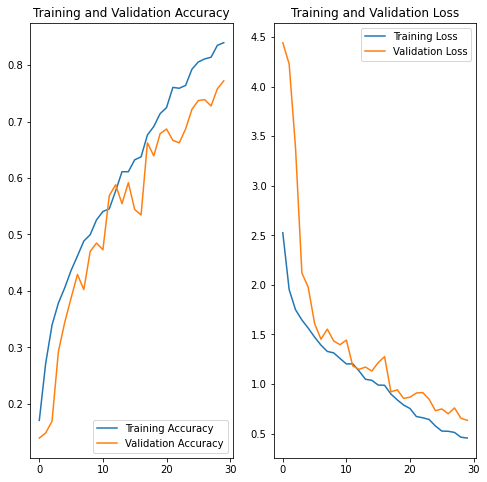

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings :**
1. Both training and validation accuracy increase with training.
2. Training & validation losses both decrease over training time.
3. There is not much difference between training and validation accuracy, hence, the problem of overfitting is no longer there.
4. Both training and validation accuracy are much better than the previous models.

Hence, handling class imbalance and introducing batch normalization and dropouts have increased accuracy as well as removed overfitting upto an extent.